# H_22082024
# Analisis del volumen profile para encontrar zonas de baja cotización (FVG like) y como se comporta el precio en esas zonas.

En este Python Notebook analizaremos, con datos de mt5, como se comporta el mercado en las zonas previamente definidas.

## Conceptos clave del perfil de mercado:

1. **Oportunidad de precio en el tiempo (TPO):**
    
    representa los niveles de precio negociados durante intervalos de tiempo específicos. En un gráfico de perfil de mercado, las TPO indican la frecuencia con la que se negoció cada nivel de precio durante una sesión.
    
2. **Área de valor:**
    
    rango de precios en el que se produjo el 70 % de la actividad comercial durante una sesión. Esta área representa el valor justo percibido del mercado.
    
3. **Punto de control (POC):**
    
    el nivel de precio con el mayor volumen durante la sesión. El POC suele ser un nivel clave de soporte o resistencia.
    
4. **Balance inicial (IB):**
    
    rango de precios negociados durante la primera hora de la sesión de negociación. Proporciona una visión anticipada de la estructura del mercado del día.

In [36]:
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import pytz
from datetime import datetime
import matplotlib.pyplot as plt
import json
import plotly.express as px
import plotly.graph_objects as go

## 1. Definición de zonas de baja cotización para posterior analisis.
El primer paso a dar es definir como encontraremos las **zonas de baja cotización** en una sesion de mercado de forma objetiva.

A continuación, definiremos que es una zona de baja cotización para nuestro estudio:

1. Analisis basado en el *volumen profile*, el cual analiza el numero de cotizaciónes por precio que tiene lugar en una sesión de trading predefinida (en nuestro estudio, una sesión será un dia 1D).
2. La media y la StdDev del volumen profile de la sesión nos ayudarán a analizar correctamente las zonas.

Por tanto, una **zona de baja cotización** consiste en:
- Los niveles de precio que se encuentran N*StdDev(mean(volume_profile)) por debajo.

In [37]:
# connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()

# request connection status and parameters
print(mt5.terminal_info())
# get data on MetaTrader 5 version
print(mt5.version())

# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")
# create 'datetime' objects in UTC time zone to avoid the implementation of a local time zone offset
utc_from = datetime(2024, 6, 10, tzinfo=timezone)
utc_to = datetime(2024, 6, 11, tzinfo=timezone)

# request AUDUSD ticks within 11.01.2020 - 11.01.2020
ohlcv = mt5.copy_rates_range("GC_V", mt5.TIMEFRAME_M1, utc_from, utc_to)

mt5.shutdown()

TerminalInfo(community_account=True, community_connection=True, connected=True, dlls_allowed=True, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=True, build=4410, maxbars=100000, codepage=1252, ping_last=45856, community_balance=0.0, retransmission=0.9587199302308679, company='MetaQuotes Software Corp.', name='MetaTrader 5', language='Spanish', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\iamfr\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\iamfr\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
(500, 4410, '21 Jun 2024')


True

In [48]:
# convert time in seconds into the datetime format
df = pd.DataFrame(ohlcv)
df['time']=pd.to_datetime(df['time'], unit='s')

df = df.set_index('time')
del df['real_volume']
del df['spread']

# display data
print("\nDisplay dataframe with ticks")
print(df.head(10)) 


Display dataframe with ticks
                       open    high     low   close  tick_volume
time                                                            
2024-06-10 02:00:00  2338.3  2338.8  2338.1  2338.2          100
2024-06-10 02:01:00  2338.1  2338.4  2337.8  2338.4           74
2024-06-10 02:02:00  2338.3  2338.8  2338.3  2338.7           76
2024-06-10 02:03:00  2338.8  2339.0  2338.6  2338.9           59
2024-06-10 02:04:00  2338.8  2339.5  2338.5  2339.3          113
2024-06-10 02:05:00  2339.2  2339.3  2338.9  2339.0           77
2024-06-10 02:06:00  2338.9  2338.9  2338.3  2338.3          117
2024-06-10 02:07:00  2338.4  2338.6  2338.1  2338.3           74
2024-06-10 02:08:00  2338.2  2338.4  2338.1  2338.4           52
2024-06-10 02:09:00  2338.3  2338.3  2338.1  2338.2           42


In [58]:
def create_market_profile(data):
    profile = data.groupby('close')['tick_volume'].sum().reset_index()
    total_volume = profile['tick_volume'].sum()
    profile['volume_cumsum'] = profile['tick_volume'].cumsum()

    value_area_cutoff = total_volume * 0.70
    value_area_df = profile[profile['volume_cumsum'] <= value_area_cutoff]
    POC = profile.loc[profile['tick_volume'].idxmax(), 'close']

    return profile, value_area_df, POC

def plot_market_profile(profile, value_area_df, POC):
    plt.figure(figsize=(10, 6))
    plt.barh(profile['close'], profile['tick_volume'], color='blue', edgecolor='black')
    plt.barh(value_area_df['close'], value_area_df['tick_volume'], color='green', edgecolor='black')
    plt.axhline(POC, color='red', linestyle='--', label=f'POC: {POC}')

    plt.xlabel('Volume')
    plt.ylabel('Price')
    plt.title(f'Market Profile')
    plt.legend()
    plt.show()

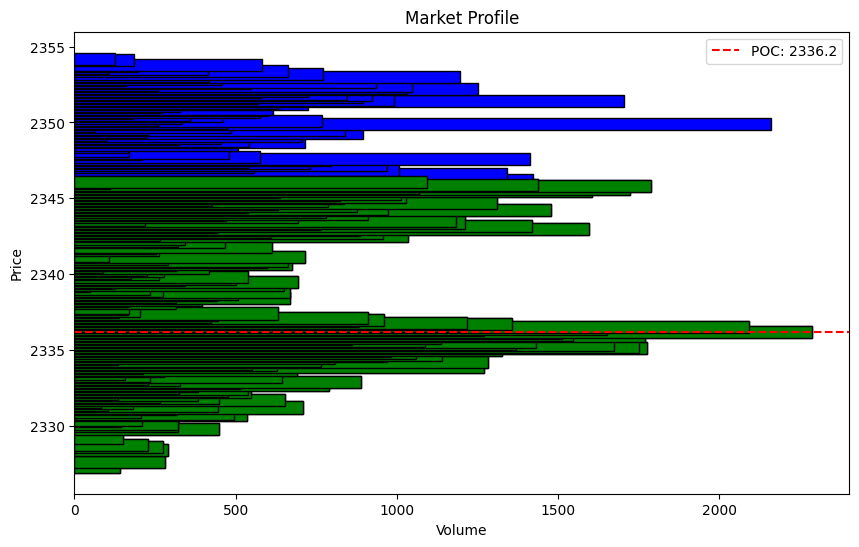

In [60]:
profile, value_area_df, POC = create_market_profile(df)
plot_market_profile(profile, value_area_df, POC)

In [99]:
# Calculamos datos importantes para el analisis del VolumeProfile
mean = profile['tick_volume'].mean()
stddev = profile['tick_volume'].std()
threshold = mean + stddev * 0.5

C:\Users\iamfr\AppData\Local\Temp\ipykernel_16132\2899680116.py:10: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



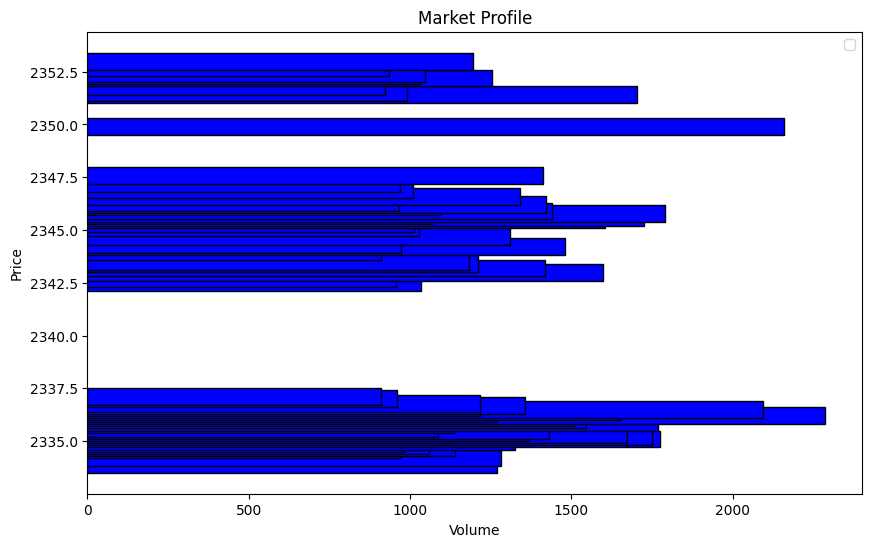

In [101]:
no_fair_value_prices = profile # En realidad son los precios que superan el threshold, pero mas tarde buscaremos los huecos.

no_fair_value_prices['tick_volume'] = no_fair_value_prices['tick_volume'][no_fair_value_prices['tick_volume'] > threshold]

plt.figure(figsize=(10, 6))
plt.barh(no_fair_value_prices['close'], no_fair_value_prices['tick_volume'], color='blue', edgecolor='black')
plt.xlabel('Volume')
plt.ylabel('Price')
plt.title(f'Market Profile')
plt.legend()
plt.show()

In [119]:
# Vamos a definir las zonas

vp_max = profile['close'].max()
vp_min = profile['close'].min()

no_fair_value_prices.sort_values(by=['close'])

zones = []
tmp1 = 0
tmp2 = 0
for index, row in no_fair_value_prices.iterrows():
        print(row['tick_volume'])


# TO-DO - Crear funcion que extraiga la zona mas grande sin suficiente cotización
def get_no_fair_value_zone():
        return False

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1271.0
nan
nan
1281.0
nan
nan
nan
969.0
1140.0
1060.0
983.0
1325.0
1776.0
1750.0
1672.0
1369.0
1431.0
1086.0
nan
1138.0
1768.0
1546.0
1513.0
2288.0
1269.0
1652.0
2093.0
1218.0
1357.0
1216.0
nan
959.0
909.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1035.0
nan
958.0
nan
nan
1597.0
nan
1419.0
nan
1211.0
1183.0
nan
nan
nan
910.0
nan
1479.0
973.0
nan
nan
nan
1311.0
nan
nan
nan
1028.0
nan
1013.0
nan
1605.0
1724.0
1069.0
1789.0
1439.0
nan
1092.0
1423.0
967.0
nan
nan
1341.0
nan
nan
1008.0
nan
970.0
nan
nan
nan
1412.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2159.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1703.0
991.0
nan
nan
924.0
nan
nan
nan
1253.0
1031.0
104